In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

df = pd.read_csv("../data/parkinsons.csv")
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [16]:
df["status"].value_counts()


status
1    147
0     48
Name: count, dtype: int64

In [ ]:
#Classify Data Types 
#Categorical: status (0 = healthy, 1 = Parkinson’s)
#Numerical (continuous): jitter, shimmer, HNR, fundamental frequency measures. 
#Ratio scale: most acoustic measures (they have a true zero)


In [ ]:
features = ["MDVP:Fo(Hz)", "MDVP:Jitter(%)", "MDVP:Shimmer", "HNR"] 

for f in features:
    mean = df[f].mean()
    median = df[f].median()
    mode = df[f].mode()[0]
    rng = df[f].max() - df[f].min()
    iqr = df[f].quantile(0.75) - df[f].quantile(0.25)
    std = df[f].std()
    
    print(f"\n--- {f} ---")
    print(f"Mean: {mean:.3f}")
    print(f"Median: {median:.3f}")
    print(f"Mode: {mode:.3f}")
    print(f"Range: {rng:.3f}")
    print(f"IQR: {iqr:.3f}")
    print(f"Std Dev: {std:.3f}")
    
    # Quick interpretation
    if abs(mean - median) > 0.2 * std:
        print("Skewed distribution (mean far from median)")
    else:
        print("Distribution looks fairly symmetric")



--- MDVP:Jitter(%) ---
Mean: 0.006
Median: 0.005
Mode: 0.004
Range: 0.031
IQR: 0.004
Std Dev: 0.005
Skewed distribution (mean far from median)

--- MDVP:Shimmer ---
Mean: 0.030
Median: 0.023
Mode: 0.015
Range: 0.110
IQR: 0.021
Std Dev: 0.019
Skewed distribution (mean far from median)

--- HNR ---
Mean: 21.886
Median: 22.085
Mode: 8.441
Range: 24.606
IQR: 5.877
Std Dev: 4.426
Distribution looks fairly symmetric


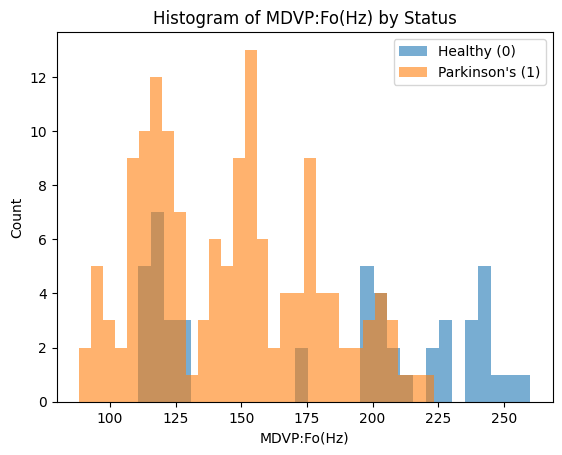

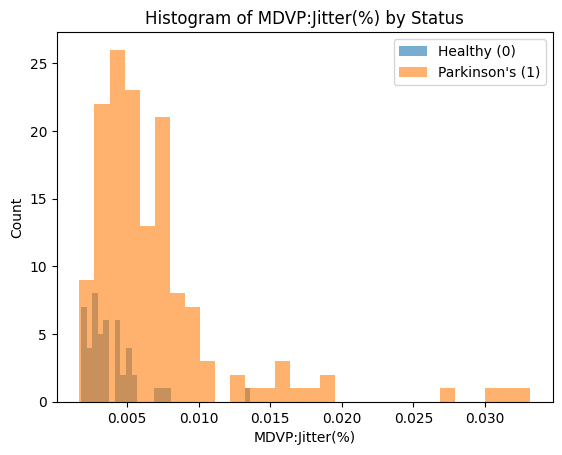

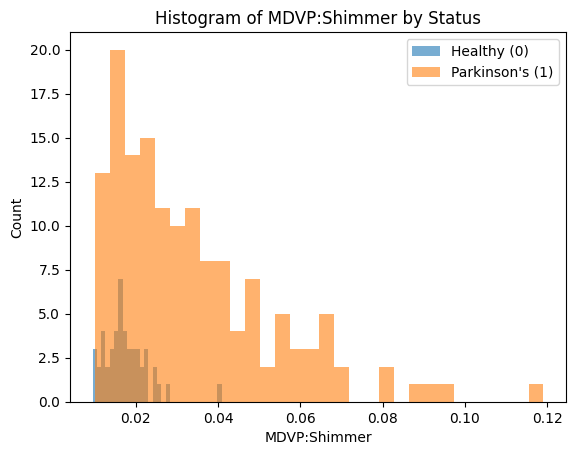

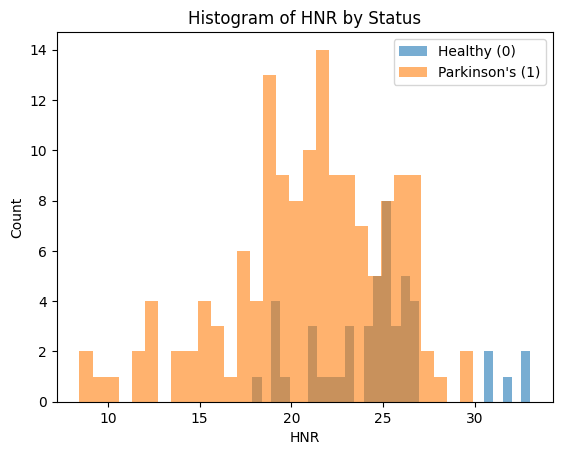

In [14]:
features = ["MDVP:Fo(Hz)", "MDVP:Jitter(%)", "MDVP:Shimmer", "HNR"]

for f in features:
    plt.hist(df[df["status"] == 0][f], bins=30, alpha=0.6, label="Healthy (0)")
    plt.hist(df[df["status"] == 1][f], bins=30, alpha=0.6, label="Parkinson's (1)")
    plt.title(f"Histogram of {f} by Status")
    plt.xlabel(f)
    plt.ylabel("Count")
    plt.legend()
    plt.show()


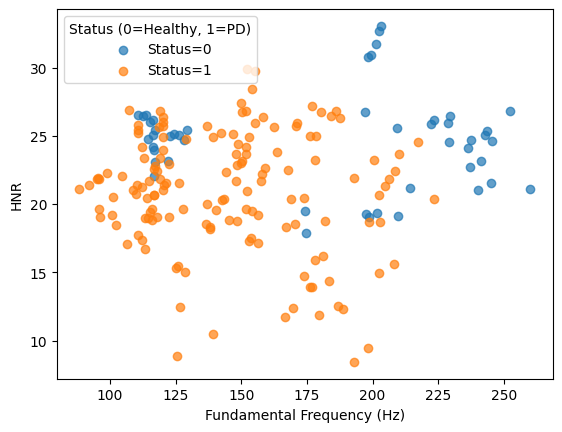

In [18]:
for status in [0, 1]:
    subset = df[df["status"] == status]
    plt.scatter(subset["MDVP:Fo(Hz)"], subset["HNR"], alpha=0.7, label=f"Status={status}")
plt.xlabel("Fundamental Frequency (Hz)")
plt.ylabel("HNR")
plt.legend(title="Status (0=Healthy, 1=PD)")
plt.show()


In [ ]:
df.groupby("status")[["MDVP:Jitter(%)","MDVP:Shimmer","HNR"]].agg(["mean","std","median"])

MDVP:Jitter(%)                     MDVP:Shimmer                      \
                 mean       std    median         mean       std    median   
status                                                                       
0            0.003866  0.002055  0.003355     0.017615  0.005544  0.016705   
1            0.006989  0.005240  0.005440     0.033658  0.019970  0.028380   

              HNR                    
             mean       std  median  
status                               
0       24.678750  3.434540  24.997  
1       20.974048  4.339143  21.414

In [26]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx-1)*x.std(ddof=1)**2 + (ny-1)*y.std(ddof=1)**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_std

for f in ["MDVP:Jitter(%)", "MDVP:Shimmer", "HNR"]:
    d = cohens_d(df[df["status"]==0][f], df[df["status"]==1][f])
    print(f"{f}: Cohen's d = {d:.2f}")

df.groupby("status")[["MDVP:Jitter(%)","MDVP:Shimmer","HNR"]].mean()


MDVP:Jitter(%): Cohen's d = -0.67
MDVP:Shimmer: Cohen's d = -0.91
HNR: Cohen's d = 0.90


,MDVP:Jitter(%),MDVP:Shimmer,HNR
status,,,
0,0.003866,0.017615,24.678750
1,0.006989,0.033658,20.974048


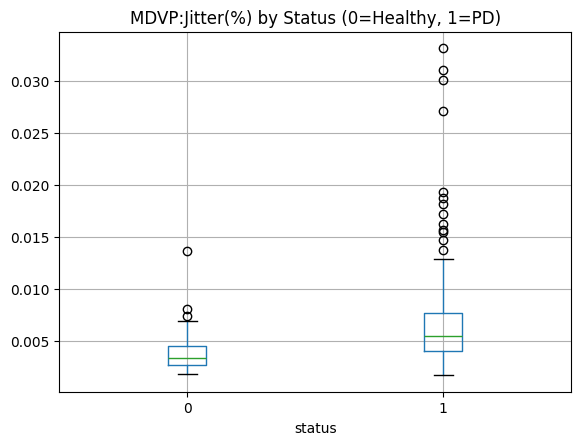

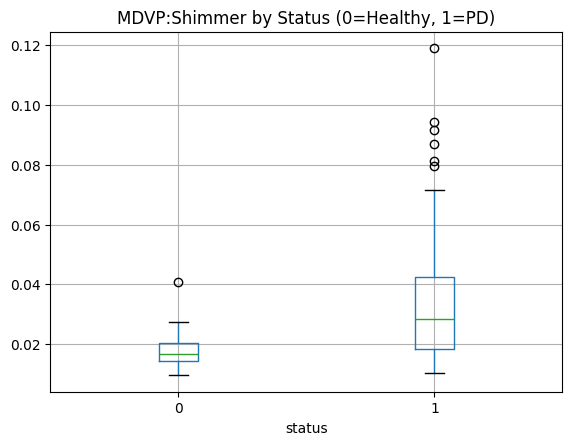

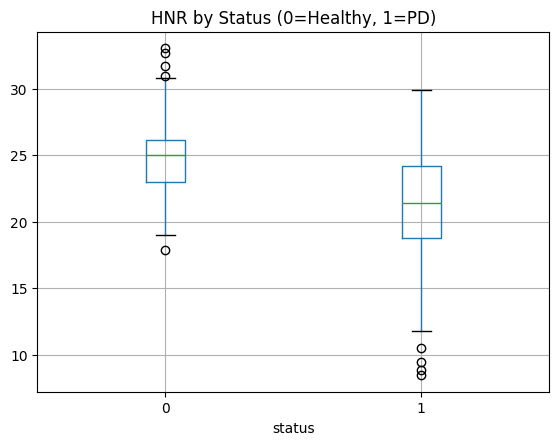

In [22]:
for f in features:
    df.boxplot(column=f, by="status")
    plt.title(f"{f} by Status (0=Healthy, 1=PD)")
    plt.suptitle("")
    plt.show()


In [ ]:
#“PD patients show increased voice instability (jitter & shimmer) and reduced voice quality (lower HNR). 
# Fundamental frequency is less discriminative alone but adds value when paired with HNR. 
# Together, these features provide clinically interpretable biomarkers for machine learning models.”